# Instances and Extensions

This chapter goes through multiple quantum variational algorithms, including:
- [Variational Quantum Eigensolver (VQE)](https://arxiv.org/abs/1304.3061)
- [Subspace-Search Variational Quantum Eigensolver (SSVQE)](https://arxiv.org/abs/1810.09434)
- [Variational Quantum Deflation (VQD)](https://arxiv.org/abs/1805.08138)
- [Quantum Sampling Regression (QSR)](https://arxiv.org/pdf/2012.02338.pdf)

## Variational Quantum Eigensolver (VQE)
VQE is one of the most widely used variational quantum algorithms, setting up a template for other algorithms to build upon.

![Overview of VQE](../resources/VQE.png)

### VQE's Theoretical Layout

- Prepare reference operators $U_R$.
  - We start from the state $|0\rangle$ and go to the reference state $|p\rangle$.
- Apply the variational form $U_V(\vec\theta_{i,j})$ to create an ansatz $U_A(\vec\theta_{i,j})$.
  - We go from the state $p$ to $U_V(\vec\theta_{i,j})|p\rangle = |\psi(\vec\theta_{i,j})\rangle$.
- Bootstrap at $i = 0$ if we have a similar problem (typically found via classical simulation or sampling).
  - Each optimizer will be bootstrapped differently, resulting in an initial set of parameter vectors $\Theta_0 := \vec\theta_{i,j}|j \in \mathcal{J}^0_{opt}$ (e.g., from an initial point $\vec\theta_0$).
- Evaluate the cost function $C(\vec\theta_{i,j}) := \langle\psi(\vec\theta)|\hat H|\psi(\vec\theta)\rangle$.
- Use a classical optimizer to select the next set of parameters $\Theta_{i+1}$.
- Repeat the process until convergence is reached.

This is a simple classical optimization loop where we evaluate the cost function. Some optimizers may require multiple evaluations to calculate a gradient, determine the next iteration, or assess convergence.

Here's the example for the following observable:

$$\hat O_1 = 2II - 2XX + 3YY - 3ZZ$$

### VQE Implementation

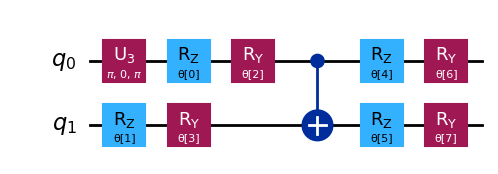

In [10]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl', style='iqp')

In [11]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session
from dotenv import load_dotenv
from os import getenv

load_dotenv()
token = getenv('IBM_TOKEN')

service = QiskitRuntimeService(channel='ibm_quantum',
                               token=token)

backend = service.backend("ibmq_qasm_simulator")
session = Session(backend=backend)

# Use estimator to get the expected values corresponding to each ansatz
estimator = Estimator(session=session)

In [22]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.998
       x: [ 3.107e+00  3.693e-01  1.554e+00  3.187e+00  1.801e+00
           -1.345e+00  3.050e+00  1.332e-01]
    nfev: 111
   maxcv: 0.0

In [ ]:
session.close()

## Subspace Search Variational Quantum Eigensolver (SSVQE)

SSVQE is a variant of VQE that allows obtaining the first $k$ eigenvalues of an observable $\hat H$ with eigenvalues $\{\lambda_0,\lambda_1,\ldots,\lambda_{N-1}\}$, where $N \geq k$. SSQVE introduces a new idea by adding weights to help prioritize optimizing for the term with the largest weight.

![SSVQE Overview](../resources/SSVQE.png)

The SSVQE algorithm relies on the fact that eigenstates corresponding to different eigenvalues are mutually orthogonal.

### SSVQE's Theoretical Layout

- Prepare several reference states by applying a unitary $U_R$ to $k$ different computational basis states.
  - This algorithm requires the usage of $k$ mutually orthogonal reference states $\{|p_j\rangle\}_{j=0}^{k-1}$.
- Apply the variational form $U_V(\vec\theta_{i,j})$ to each reference state, resulting in the following ansatz $U_A(\vec\theta_{i,j})$.
- Bootstrap at $i = 0$ if a similar problem is available (usually found via classical simulation or sampling).
- Evaluate the cost function $C(\vec\theta_{i,j}) := \sum_{j=0}^{k-1} w_j\langle\psi_j(\vec\theta)|\hat H|\psi_j(\vec\theta)\rangle$ for all prepared states on a quantum computer.
  - This can be separated into calculating the expectation value for an observable $\langle\psi_j(\vec\theta)|\hat H|\psi_j(\vec\theta)\rangle$ and multiplying that result by $w_j$.
  - Afterwards, the cost function returns the sum of all weighted expectation values.
- Use a classical optimizer to select the next set of parameters $\Theta_{i+1}$.
- Repeat the process until convergence is achieved.

In [23]:
import numpy as np


def cost_func_ssvqe(params, initialized_ansatz_list, weights, ansatz, hamiltonian, estimator):
    # """Return estimate of energy from estimator

    # Parameters:
    #     params (ndarray): Array of ansatz parameters
    #     initialized_ansatz_list (list QuantumCircuit): Array of initialized ansatz with reference
    #     weights (list): List of weights
    #     ansatz (QuantumCircuit): Parameterized ansatz circuit
    #     hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
    #     estimator (Estimator): Estimator primitive instance

    # Returns:
    #     float: Weighted energy estimate
    # """

    energies = []

    # Define SSVQE

    weighted_energy_sum = np.dot(energies, weights)
    return weighted_energy_sum

## Variational Quantum Deflation (VQD)

VQD is a variant of VQE that allows obtaining the first $k$ eigenvalues of an observable $\hat H$ with eigenvalues $\{\lambda_0,\lambda_1,\ldots,\lambda_{N-1}\}$, where $N \geq k$. VQD introduces a new idea by a penalty cost to guide the optimization process.

![VQD Overview](../resources/VQD.png)

VQD introduces a penalty term, denoted as $\beta$, to balance the contribution of each overlap term to the cost. This penalty term serves to penalize the optimization process if orthogonality is not achieved. By enforcing orthogonality with the eigenstate corresponding to $\lambda_0$, we are effectively optimizing over the subspace that corresponds to the rest of the eigenvalues $\{\lambda_1,\lambda_2\ldots,\lambda_{N-1}\}$. Here, $\lambda_1$ is the lowest eigenvalue from the rest of the eigenvalues and, therefore, the optimal solution of the new problem can be obtained using the variational theorem.

The cost function for VQD is given by 
$$C_k(\vec\theta) = \langle\psi(\vec\theta)|\hat H|\psi(\vec\theta)\rangle + \sum_{j=0}^{k-1}\beta_j|\langle\psi(\vec\theta)|\psi(\vec\theta^j)\rangle|^2$$
and we can observe that, to obtain the $k$-th eigenvalue, we need the (approximate) of the previous $k-1$ eigenvalues, which means we need to run VQE a total of $k$ times.

### VQD's Theoretical Layout

- Prepare a reference operator $U_R$.
- Apply variational form $U_V(\vec\theta_{i,j})$ to the reference state, creating the following ansatze $U_A(\vec\theta_{i,j}$.
- Bootstrap at $i=0$ if we have a similar problem (typically found via classical simulation or sampling).
  - Evaluate the cost function $C_k(\vec\theta)$, which involves computing $k$ excited states and an array of $beta$'s defining the overlap penalty for each overlap term.
  - Calculate the expectation value for an observable $\langle\psi(\vec\theta)|\hat H|\psi(\vec\theta)\rangle$.
  - Calculate the penalty $\sum_{j=0}^{k-1}\beta_j|\langle\psi(\vec\theta)|\psi(\vec\theta^j)\rangle|^2$.
  - The cost function should then return the sum of these two terms.
- Use a classical optimizer to select the next set of parameters $\Theta_{i+1}$.
- Repeat the process until convergence is reached.

### VQD Implementation

We'll create a function for an overlap penalty. This penalty will be used in the cost function at each iteration. This process will be repeated for each excited state.

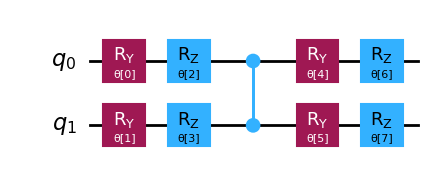

In [27]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

ansatz.decompose().draw('mpl', style='iqp')

First, we'll setup a function that calculates the state fidelity -- a percentage of overlap between two states that we'll use as a penalty for VQD:

In [28]:
from qiskit.circuit import ParameterVector


def calculate_overlap(circuits_1, circuits_2, parameters, sampler):
    def get_global_fidelity(probability_distribution):
        """Process the probability distribution of a measurement to determine the
        global fidelity.
        """
        return probability_distribution.get(0, 0)

    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit

    def construct_fidelity_circuits(circuits_1, circuits_2):
        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
        circuits = []
        for (circuit_1, circuit_2) in zip(circuits_1, circuits_2):
            # re-parametrize input circuits
            parameters_1 = ParameterVector("x", circuit_1.num_parameters)
            parametrized_circuit_1 = circuit_1.assign_parameters(parameters_1)
            parameters_2 = ParameterVector("y", circuit_2.num_parameters)
            parametrized_circuit_2 = circuit_2.assign_parameters(parameters_2)

            circuit = create_fidelity_circuit(
                parametrized_circuit_1, parametrized_circuit_2
            )
            circuits.append(circuit)

        return circuits

    circuits = construct_fidelity_circuits(circuits_1, circuits_2)

    job = sampler.run(circuits=circuits, parameter_values=parameters)
    result = job.result()

    raw_fidelities = [
        get_global_fidelity(prob_dist) for prob_dist in result.quasi_dists
    ]

    return np.clip(raw_fidelities, 0, 1).tolist()

Next, we'll setup our runtime primitives

In [32]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session
from dotenv import load_dotenv
from os import getenv

load_dotenv()
token = getenv('IBM_TOKEN')

# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

It's time to write VQD's cost function:

In [33]:
import numpy as np


def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):
    if len(parameters.shape) == 1:
        parameters = np.reshape(parameters, (-1, ansatz.num_parameters))

    batch_size = len(parameters)

    estimator_job = estimator.run(
        batch_size * [ansatz], batch_size * [hamiltonian], parameters
    )

    total_cost = np.zeros(batch_size)

    if step > 1:
        # compute overlap cost
        batched_prev_states = [state for state in prev_states for _ in range(batch_size)]
        costs = calculate_overlap(
            batch_size * [ansatz] * (step - 1),
            batched_prev_states,
            np.tile(parameters, (step - 1, 1)),
            sampler
        )

        costs = np.reshape(costs, (step - 1, -1))
        for state, cost in enumerate(costs):
            total_cost += np.real(betas[state] * cost)

    estimator_result = estimator_job.result()

    values = estimator_result.values + total_cost

    return values if len(values) > 1 else values[0]

In [34]:
from qiskit.quantum_info import SparsePauliOp

k = 3
betas = [33, 33, 33]
x0 = np.zeros(8)
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

prev_states = []
prev_opt_parameters = []
eigenvalues = []

In [ ]:
from scipy.optimize import minimize

for step in range(1, k + 1):

    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))

    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable),
                      method="COBYLA")
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0285
       x: [ 5.428e-02 -1.551e-02  9.903e-01  3.557e-03 -1.560e-02
           -6.365e-03  3.996e-03  7.728e-03]
    nfev: 82
   maxcv: 0.0


/var/folders/38/kddld1k955775hyf55xdjbm40000gn/T/ipykernel_1945/1142198498.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use assign_parameters() instead
  prev_states.append(ansatz.bind_parameters(prev_opt_parameters))


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.4425
       x: [-2.630e-01  1.288e+00  3.355e-01 -2.388e-01  2.948e+00
            1.873e+00  2.003e-01 -5.800e-02]
    nfev: 93
   maxcv: 0.0


Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/Users/peterbuschenreiter/Documents/KDG/Year 3/lab/variational-algorithm-design/.venv/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
  File "/Users/peterbuschenreiter/Documents/KDG/Year 3/lab/variational-algorithm-design/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 278, in fun
    self._update_fun()
  File "/Users/peterbuschenreiter/Documents/KDG/Year 3/lab/variational-algorithm-design/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 262, in _update_fun
    self._update_fun_impl()
  File "/Users/peterbuschenreiter/Documents/KDG/Year 3/lab/variational-algorithm-design/.venv/lib/python3.10/site-packages/sc

In [ ]:
eigenvalues

In [ ]:
session.close()

## Quantum Sampling Regression (QSR)

One of the main issues with VQE is the multiple calls to a quantum computer that are required to obtain the parameters for each step, including $k,k-1$, etc. This is especially problematic when access to quantum devices is queued. While a `Session` can be used to group multiple iterative calls, an alternative approach is to use sampling. By utilizing more classical ../resources, we can complete the full optimization process in a single call. This is where Quantum Sampling Regression comes into play. Since access to quantum computers is still a low-offer/high-demand commodity, we find this trade-off to be both possible and convenient for many current studies. This approach harnesses all available classical capabilities while still capturing many of the inner workings and intrinsic properties of quantum computations that do not appear in simulation.

![QSR Overview](../resources/QSR.png)

The idea behind QSR is that the cost function $C(\theta) := \langle\psi(\theta)|\hat H|\psi(\theta)\rangle$ can be expressed as a Fourier series in the following manner:

$$C(\vec\theta) := \langle\psi(\theta)|\hat H|\psi(\theta)\rangle := a_0 + \sum_{k=1}^S[a_k\cos(k\theta) + b_k\sin(k\theta)]$$

Depending on the periodicity and bandwidth of the original function, the set $S$ may be finite or infinite. For the purpose of this discussion, we will assume that it is infinite. The next step is to sample the ocst function $C(\theta)$ multiple times in order to obtain the Fourier coefficients $\{a_0,a_k,b_k\}_{k=1}^S$. Specifically, since we have $2S + 1$ unknowns, we will need to sample the cost function $2S+1$ times.

If we then sample the cost function for $2S+1$ parameter values $\{\theta_1, \ldots, \theta_{2S+1}\}$, we can obtain the following system:

$$
\begin{pmatrix}
    1 & \cos(\theta_1) & \sin(\theta_1) & \cos(2\theta_1) & \ldots & \sin(S\theta_1) \\ 
    1 & \cos(\theta_2) & \sin(\theta_2) & \cos(2\theta_2) & \ldots & \sin(S\theta_2) \\ 
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 
    1 & \cos(\theta_{2S+1}) & \sin(\theta_{2S+1}) & \cos(2\theta_{2S+1}) & \ldots & \sin(S\theta_{2S+1}) 
\end{pmatrix}
\begin{pmatrix}
    a_0 \\ 
    a_1 \\ 
    b_1 \\ 
    a_2 \\ 
    \vdots \\ 
    b_S
\end{pmatrix} = 
\begin{pmatrix}
    C(\theta_1) \\ 
    C(\theta_2) \\ 
    \vdots \\ 
    C(\theta_{2S+1})
\end{pmatrix}
$$ 

that we'll rewrite as $$F_a = c$$

In practice, this system is generally not consistent because the cost function values $c$ are not exact. Therefore, it is usually a good idea to normalize themm by multiplying them by $F^\dagger$ on the left, which results in:

$$F^\dagger Fa = F^\dagger c$$

This new system is always consistent, and its solution is a least-squares solution to the original problem. If we have $k$ parameters instead of just one, and each parameter $\theta^i$ has its own $S_i$ for $i \in 1,\ldots,k$, then the total number of samples required is:

$$
T = \prod_{i=1}^k(2S_i + 1) \leq \prod_{i=1}^k(2S_{max} + 1) = (2S_{max} + 1)^n
$$

where $S_{max} = \max_i(S_i)$. Furthermore, adjusting $S_{max}$ as a tunable parameter (instead of inferring it) opens up new possibilities, such as:
- **Oversampling**: to improve accuracy.
- **Undersampling**: to boost performance by reducing runtime overhead or eliminating local minima.

### QSR's Theoretical Layout

- Prepare a reference operators $U_R$.
  - We'll go from the state $|0\rangle$ to the reference state $|p\rangle$.
- Apply the variational form $U_V(\vec\theta_{i,j})$ to create an ansatz $U_A(\vec\theta_{i,j})$.
  - Determine the bandwidth associated with each parameter in the ansatz. An upper bound is sufficient.
- Bootstrap at $i = 0$ if we have a similar problem (typically found via classical simulation or sampling).
- Sample the cost function $C(\vec\theta) := a_0 + \sum_{k=1}^S[a_k\cos(k\theta) + b_k\sin(k\theta)]$ at least $T$ times.
  - $T = \prod_{i=1}^k(2S_i+1)\leq\prod_{i=1}^k(2S_{max}+1)=(2S_{max}+1)^n$
  - Decide whether to oversample/undersample to balance accuracy vs speed by adjusting $T$.
- Compute the Fourier coefficients from the samples (i.e., solve the normalized linear system of equations).
- Solve for the global minimum of the resulting regression function on a classical machine. 